# IDS - analysis

In [5]:
%run ../rule_miner.py
%run ../rules.py
%run ../IDS_smooth_local.py

In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyarc import TransactionDB
from pyarc.algorithms import (
    top_rules,
    createCARs,
    M1Algorithm
)
from pyarc import CBA, TransactionDB

import random

## Parameter initialization and dataset loading

In [193]:
lambda_array = [1.0]*7 

In [194]:
df = pd.read_csv('../data/iris0.csv', ',')
df_raw = df.iloc[:, :-1]
Y = df.iloc[:, -1]

txns_train = TransactionDB.from_DataFrame(df)

rules = run_fim_apriori(df_raw, 0.35)

list_of_rules = createrules(rules, list(set(Y)))
print(len(list_of_rules), "rules created")

prepare_caches(list_of_rules, df, Y)
prepare_overlap(list_of_rules, df)
print("caches prepared")

def optimize(param):
    lambda_array = [1.0]*7     # use separate hyperparamter search routine
    #lambda_array = [1, 0, 0, 1, 0, 0, 0]
    
    s1 = smooth_local_search(list_of_rules, df, Y, lambda_array, 0.33, param)
    f1 = func_evaluation(s1, list_of_rules, df, Y, lambda_array, len(list_of_rules))

    return f1, s1

def f(x):
    return x * x

running fim apriori function
dataset processed
apriori runned
apriori results processed
15 rules created
caches prepared


In [196]:
df.head()

,sepallength,petalwidth,sepalwidth,petallength,class
0,-inf_to_5.55,-inf_to_0.8,3.35_to_inf,-inf_to_2.45,Iris-setosa
1,-inf_to_5.55,-inf_to_0.8,2.95_to_3.35,-inf_to_2.45,Iris-setosa
2,-inf_to_5.55,-inf_to_0.8,2.95_to_3.35,-inf_to_2.45,Iris-setosa
3,-inf_to_5.55,-inf_to_0.8,3.35_to_inf,-inf_to_2.45,Iris-setosa
4,-inf_to_5.55,-inf_to_0.8,3.35_to_inf,-inf_to_2.45,Iris-setosa


## Mined rules for IDS

In [16]:
for r in list_of_rules:
    r.print_rule()

If petalwidth == 0.8_to_1.75, then Iris-virginica
If petalwidth == 0.8_to_1.75, then Iris-setosa
If petalwidth == 0.8_to_1.75, then Iris-versicolor
If petallength == 4.75_to_inf, then Iris-virginica
If petallength == 4.75_to_inf, then Iris-setosa
If petallength == 4.75_to_inf, then Iris-versicolor
If sepalwidth == 2.95_to_3.35, then Iris-virginica
If sepalwidth == 2.95_to_3.35, then Iris-setosa
If sepalwidth == 2.95_to_3.35, then Iris-versicolor
If sepalwidth == -inf_to_2.95, then Iris-virginica
If sepalwidth == -inf_to_2.95, then Iris-setosa
If sepalwidth == -inf_to_2.95, then Iris-versicolor
If sepallength == -inf_to_5.55, then Iris-virginica
If sepallength == -inf_to_5.55, then Iris-setosa
If sepallength == -inf_to_5.55, then Iris-versicolor


## Model training

## CBA model

In [199]:
cba = CBA(support=0.35, confidence=0, algorithm="m1")
cba.fit(txns_train)

cba_accuracy = cba.rule_model_accuracy(txns_train)

# precompute values for cover and correct cover

print("CBA accuracy:", cba_accuracy)

print("CBA rules:")
for r in cba.clf.rules:
    print("\t", r)

CBA accuracy: 0.9481481481481482
CBA rules:
	 CAR {petallength=4.75_to_inf} => {class=Iris-virginica} sup: 0.33 conf: 0.90 len: 2, id: 161
	 CAR {petalwidth=0.8_to_1.75} => {class=Iris-versicolor} sup: 0.33 conf: 0.90 len: 2, id: 170


## IDS model

In [26]:
results = list(map(optimize, [0.33, -1.0]))

(f1, s1), (f2, s2) = results 

result_obj = 0
result_set = {}
if f1 > f2:
    print("The Solution Set is: "+str(s1))
    result_set = list(s1)
    result_obj = f1
else:
    print("The Solution Set is: "+str(s2))
    result_set = list(s2)
    result_obj = f1

2/n*n OPT value is 550.7644444444444
Estimating omega for rule 0
Standard Error 91.85175556297223
Estimating omega for rule 1
Standard Error 89.97462975750442
Estimating omega for rule 2
Standard Error 89.68495972012252
Estimating omega for rule 3
Standard Error 98.16863552072016
Estimating omega for rule 4
Standard Error 67.73321194214843
Estimating omega for rule 5
Standard Error 101.93690205220089
Estimating omega for rule 6
Standard Error 75.58264351026631
Estimating omega for rule 7
Standard Error 104.73226818893976
Estimating omega for rule 8
Standard Error 94.44684219178532
Estimating omega for rule 9
Standard Error 109.80409828417152
Estimating omega for rule 10
Standard Error 94.91727977560251
Estimating omega for rule 11
Standard Error 91.13524565172357
Estimating omega for rule 12
Standard Error 64.41960105433749
Estimating omega for rule 13
Standard Error 70.94088383999737
Estimating omega for rule 14
Standard Error 102.39257785601454
2/n*n OPT value is 549.8577777777778
Es

## Evaluation

We will look at the value of the objective with empty set given as an argument. Then we will subtract this value from the objective of the solution to get the scaled objective.

In [202]:
np_rules = np.array(list_of_rules)
solution_rules = np_rules[result_set]

n = len(list_of_rules)
random_sample_soln_set = random.sample(range(0, n), len(result_set))
random_sample_objective = func_evaluation(random_sample_soln_set, list_of_rules, df, Y, [1.0]*7, n)

empty_obj = func_evaluation({}, list_of_rules, df, Y, [1.0]*7, n)

print("Objective with empty set:", empty_obj)

Objective with empty set: 62805.0


### Solution rules

In [208]:
for r in solution_rules:
    r.print_rule()

If petalwidth == 0.8_to_1.75, then Iris-versicolor
If sepalwidth == 2.95_to_3.35, then Iris-virginica
If sepallength == -inf_to_5.55, then Iris-versicolor


In [209]:
print("objective_value", result_obj)
print("Scaled objective value", result_obj - empty_obj)

objective_value 62746.0
Scaled objective value -59.0


In [210]:
print("---------------------")
print("Random sampled rules")
print("---------------------")
print("objective_value:", random_sample_objective)
print("scaled objective value", random_sample_objective - empty_obj)
print("---------------------")
for rule in np_rules[random_sample_soln_set]:
    rule.print_rule()





print("----------------------")



pred = predict(result_set, list_of_rules, df, Y)
print("IDS accuracy", accuracy_score(pred, Y))
print("CBA accuracy", cba_accuracy)


print("---------------------")
print("Number of rules:")
print("Total:", len(list_of_rules))
print("CBA:", len(cba.clf.rules))
print("IDS smooth:", len(solution_rules))
print("Random:", len(random_sample_soln_set))
print("---------------------")


print("---------")
better = []
for _ in range(20):
    rand_soln = random.sample(range(len(list_of_rules)), len(result_set))
    obj_val = func_evaluation(rand_soln, list_of_rules, df, Y, lambda_array, len(list_of_rules))
    better.append(result_obj < obj_val)
    print("{} -- {} rules sampled, objective value: {}, scaled obj: {}, better than SLS: {}".format(_, len(result_set), obj_val, obj_val - empty_obj, result_obj < obj_val))


print("-----------------")
print("better", np.sum(better) / len(better))


print()
print("---------------------")
print("Random test")

for i in range(len(list_of_rules)):
    rand_soln = random.sample(range(len(list_of_rules)), i)
    obj_val = func_evaluation(rand_soln, list_of_rules, df, Y, [1.0]*7, n)
    print("{} rules sampled, objective value: {}, scaled obj value: {}".format(i, obj_val, obj_val - empty_obj))

print("---------------------")


---------------------
Random sampled rules
---------------------
objective_value: 62744.0
scaled objective value -61.0
---------------------
If petallength == 4.75_to_inf, then Iris-versicolor
If petalwidth == 0.8_to_1.75, then Iris-versicolor
If sepalwidth == 2.95_to_3.35, then Iris-virginica
----------------------
IDS accuracy 0.8148148148148148
CBA accuracy 0.9481481481481482
---------------------
Number of rules:
Total: 15
CBA: 2
IDS smooth: 3
Random: 3
---------------------
---------
0 -- 3 rules sampled, objective value: 62725.0, scaled obj: -80.0, better than SLS: False
1 -- 3 rules sampled, objective value: 62636.0, scaled obj: -169.0, better than SLS: False
2 -- 3 rules sampled, objective value: 62725.0, scaled obj: -80.0, better than SLS: False
3 -- 3 rules sampled, objective value: 62578.0, scaled obj: -227.0, better than SLS: False
4 -- 3 rules sampled, objective value: 62701.0, scaled obj: -104.0, better than SLS: False
5 -- 3 rules sampled, objective value: 62780.0, scale

D:\programy\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


### Experimenting with IDS objective

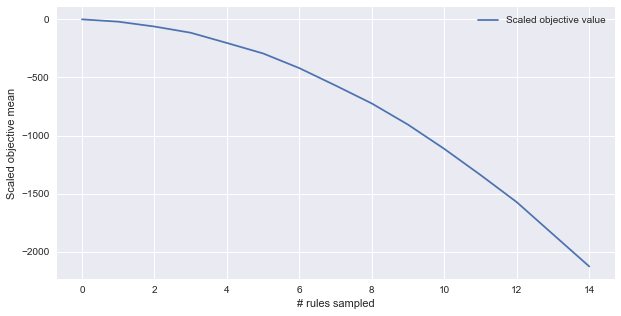

In [211]:
scaled_obj_dict = {}

rule_size = len(list_of_rules)
sample_size = 100

for rule_num in range(rule_size):
    scaled_obj_dict[rule_num] = []
    
    for i in range(sample_size):
        rand_soln = random.sample(range(len(list_of_rules)), rule_num)
        obj_val = func_evaluation(rand_soln, list_of_rules, df, Y, [1.0]*7, n)
        
        scaled_obj_val = obj_val - empty_obj
        scaled_obj_dict[rule_num].append(scaled_obj_val)
        

        
scaled_obj_means = [ np.mean(val) for val in scaled_obj_dict.values() ]

plt.figure(figsize=(10, 5))
plt.plot(range(rule_size), scaled_obj_means, label="Scaled objective value")
plt.legend()
plt.xlabel("# rules sampled")
plt.ylabel("Scaled objective mean")
plt.show()

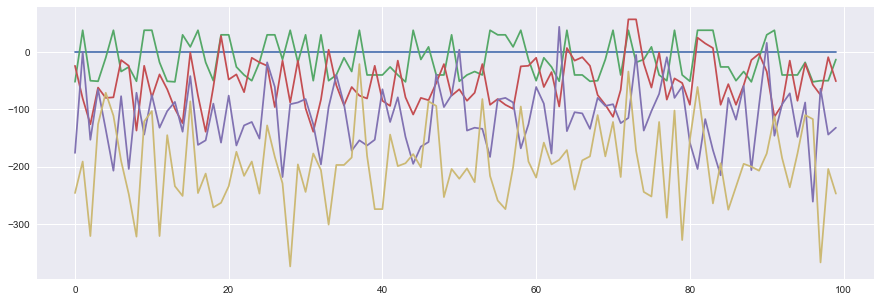

In [84]:
plt.figure(figsize=(15, 5))

for rule_num in range(rule_size)[:5]:
    plt.plot(scaled_obj_dict[rule_num], label="sample size - {}".format(rule_num))

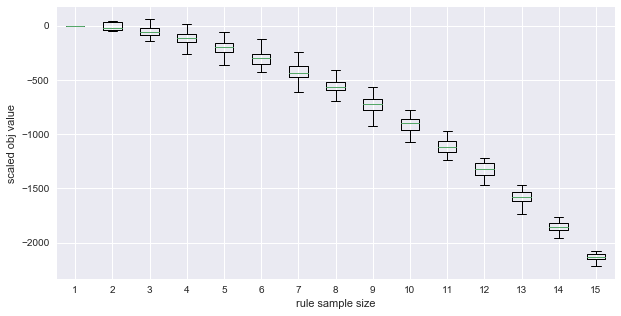

In [106]:
from itertools import chain

scaled_obj_list = list(scaled_obj_dict.values())
scaled_obj_array = list(chain(*scaled_obj_list))

scaled_obj_matrix = np.array(scaled_obj_list).T #np.array(scaled_obj_array).reshape(sample_size, rule_size)

plt.figure(figsize=(10, 5))
plt.xlabel("rule sample size")
plt.ylabel("scaled obj value")
plt.boxplot(scaled_obj_matrix);

## IDS Objective investigation

In [129]:
    # f0 term
    def f0(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        f0 = len_list_rules - len(soln_set) # |S| - size(R)

        return f0
    
        
    # f1 term
    def f1(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        Lmax = max_rule_length(list_rules)
        sum_rule_length = 0.0
        for rule_index in soln_set:
            sum_rule_length += list_rules[rule_index].get_length()
    
        f1 = Lmax * len_list_rules - sum_rule_length

        return f1
        
    # f2 term - intraclass overlap
    def f2(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        
        sum_overlap_intraclass = 0.0
        for r1_index in soln_set:
            for r2_index in soln_set:
                if r1_index >= r2_index:
                    continue
                if list_rules[r1_index].class_label == list_rules[r2_index].class_label:
                    overlap_tmp = list_rules[r1_index].overlaps[list_rules[r2_index]]
                    sum_overlap_intraclass += len(overlap_tmp)
        f2 = df.shape[0] * len_list_rules * len_list_rules - sum_overlap_intraclass

        return f2
        
    # f3 term - interclass overlap
    def f3(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        
        sum_overlap_interclass = 0.0
        for r1_index in soln_set:
            for r2_index in soln_set:
                if r1_index >= r2_index:
                    continue
                if list_rules[r1_index].class_label != list_rules[r2_index].class_label:
                    overlap_tmp = list_rules[r1_index].overlaps[list_rules[r2_index]]
                    sum_overlap_interclass += len(overlap_tmp)
        f3 = df.shape[0] * len_list_rules * len_list_rules - sum_overlap_interclass

        return f3
        
    # f4 term - coverage of all classes
    def f4(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        classes_covered = set() # set
        for index in soln_set:
            classes_covered.add(list_rules[index].class_label)
        f4 = len(classes_covered)

        return f4
        
    # f5 term - accuracy
    def f5(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        sum_incorrect_cover = 0.0
        for index in soln_set:
            sum_incorrect_cover += len(list_rules[index].get_incorrect_cover(df,Y))
        f5 = df.shape[0] * len_list_rules - sum_incorrect_cover

        return f5
    
    #f6 term - cover correctly with at least one rule
    def f6(soln_set, list_rules, df):
        atleast_once_correctly_covered = set()
        for index in soln_set:
            correct_cover, full_cover = list_rules[index].get_correct_cover(df,Y)
            atleast_once_correctly_covered = atleast_once_correctly_covered.union(set(correct_cover))
        f6 = len(atleast_once_correctly_covered)

        return f6
    
    
fs = [f0, f1, f2, f3, f4, f5, f6]

We can see that every objective contributes differently to the final value of the objective function. For example, we could say that having short concise rules is just as important as the rules having no overlap (in fact, we can specifically set this with the lambda array hyperparameter), but $f_0$ is very small compared to $f_2$.

Here, we will test the hypothesis that no matter how many random solutions we sample, $f_0$ will always be disproportionately smaller than $f_2$ and $f_3$. This is mainly due do the definition of $f_0$ and $f_3$. In $f_0$ we are subtracting the total antecedent length of solution set from the length of all the mined rules.

In [132]:
print("objective value:", obj_val)

for f_idx in range(7):
    print("f{}".format(f_idx), fs[f_idx](result_set, list_of_rules, df))

f1(result_set, list_of_rules, df)

objective value: 60716.0
f0 12
f1 12.0
f2 30364.0
f3 30344.0
f4 2
f5 1947.0
f6 65


12.0

#### Modified f3 term

so that the values will not be so extreme

In [191]:
def f3_modif(soln_set, list_rules, df):
        len_list_rules = len(list_rules)
        
        sum_overlap_interclass = 0.0
        for r1_index in soln_set:
            for r2_index in soln_set:
                if r1_index >= r2_index:
                    continue
                if list_rules[r1_index].class_label != list_rules[r2_index].class_label:
                    overlap_tmp = list_rules[r1_index].overlaps[list_rules[r2_index]]
                    sum_overlap_interclass += len(overlap_tmp)
        f3 = df.shape[0] - sum_overlap_interclass

        return f3
    
f3_modif(result_set, list_of_rules, df)

104.0

#### Ranges of different objectives

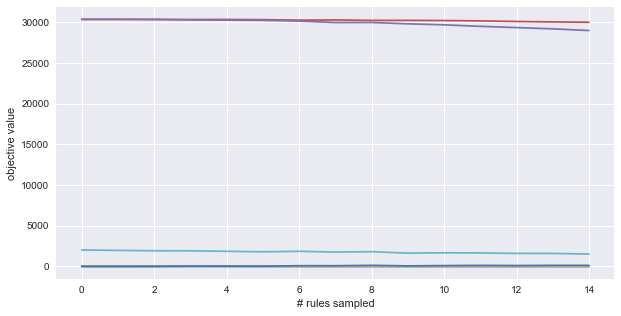

In [190]:
function_values = []

for rule_num in range(rule_size):
    rand_soln = random.sample(range(len(list_of_rules)), rule_num)
    f_vals = [ f(rand_soln, list_of_rules, df) for f in fs ]
        
    function_values.append(f_vals)
        

plt.figure(figsize=(10, 5))
plt.xlabel("# rules sampled")
plt.ylabel("objective value")
plt.plot(np.array(function_values));